# Классификация 128x128 + U-Net c бэкбоном

In [1]:
import os
from pathlib import Path

import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import json
import torch
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

# Import Utils.
from torch.utils.data import DataLoader
from src.utils.metrics import CombinedLoss, dice_coefficient, iou_score, pixel_accuracy

# Import Datasets.
from src.datasets.MoonSegmentBinaryDataset import MoonSegmentationDataset

# Import models.
from src.models.model_utilizer import load_net
from src.models.customUNet import customUNet
from src.models.customResNetUNet import customResNetUNet

from src.main import set_seed
from src.train import MetricsHistory

Настройки форматирования графиков общие.

In [2]:
user_fontsize = 16

# legend_fontsize: 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'
line_type = ['-', ':']
plot_mark = ['', 'o']

plot_xlabel = 'epoch'
plot_legend = ['train', 'validation']

tab10_colors = [
    '#1f77b4',  # tab:blue
    '#ff7f0e',  # tab:orange
    '#2ca02c',  # tab:green
    '#d62728',  # tab:red
    '#9467bd',  # tab:purple
    '#8c564b',  # tab:brown
    '#e377c2',  # tab:pink
    '#7f7f7f',  # tab:gray
    '#bcbd22',  # tab:olive
    '#17becf']  # tab:cyan

Пути к файлам конфигурации.

In [3]:
# Read config-files.
hyperparameters_dir = Path("./src/hyperparameters/")


config_path = hyperparameters_dir / "config.json"
assert config_path.exists(), f"Config not found: {config_path}"
with open(config_path, "r") as f:
    general_config = json.load(f)

set_seed(general_config["seed"])
device = torch.device(general_config["device"].lower() if torch.cuda.is_available() else 'cpu')

checkpoints_dir = Path(general_config["checkpoints_dir"])
logs_dir = Path(general_config["logs_dir"])

## Часть 1. Классификатор 128×128

Настройки форматирования графиков.

In [4]:
user_figsize = (10, 6)

plot_titles = ["Losses", "Accuracy"]
plot_ylabels = ["loss", "accuracy"]
METRIC_NUM = len(plot_titles)

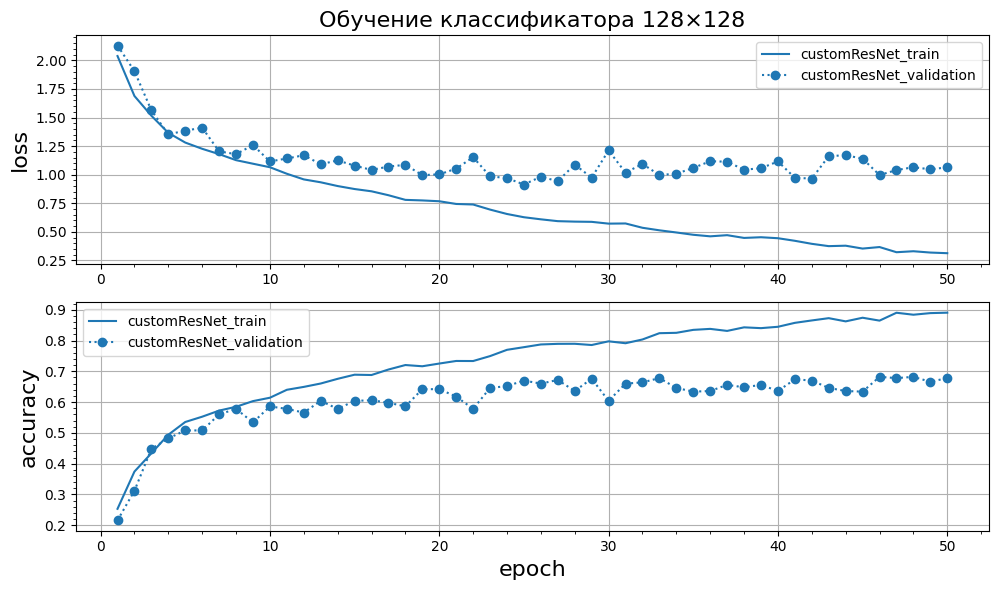

In [5]:
backbone_model_name = 'customResNet'

backbone_train_log_path = logs_dir / f"{backbone_model_name}.json"
assert backbone_train_log_path.exists(), f"Backbone log not found: {backbone_train_log_path}"
with open(backbone_train_log_path, "r") as f:
    backbone_train_log_full = json.load(f)
backbone_log_data_df = pd.DataFrame(backbone_train_log_full['train_log'])

plot_legend_local = []
fig, axs = plt.subplots(ncols=1, nrows=METRIC_NUM, figsize=user_figsize)
for k, ax in enumerate(axs):
    if k == 0:
        ax.set_title("Обучение классификатора 128×128", fontsize=user_fontsize)
    else:
        ax.set_xlabel(plot_xlabel, fontsize=user_fontsize)
    for m in range(METRIC_NUM):
        ax.plot(
            backbone_log_data_df.iloc[:,0], 
            backbone_log_data_df.iloc[:,2+2*m+k],
            marker=plot_mark[m],
            linestyle=line_type[m],
            color=tab10_colors[0]
            )
        plot_legend_local.extend([backbone_model_name + '_' + tp for tp in plot_legend])
    ax.set_ylabel(plot_ylabels[k], fontsize=user_fontsize)
    ax.legend(plot_legend_local, fontsize='medium')
    ax.grid()
    ax.minorticks_on()
    
plt.tight_layout()
plt.savefig('readme_img/backbone.png', bbox_inches='tight')
plt.show()

## Части 2,3. Модели сегментации

In [6]:
from enum import IntEnum

# user-defined index.
class usid(IntEnum):
    customUNet = 0
    customResNetUNet = 1
    customResNetUNet_pretrained = 2

# Имена моделей.
model_names = [e.name for e in usid]

In [7]:
metadata_list = []
train_log_list = []
train_log_df_list = []
checkpoints_file_list = []

for name in model_names:
    train_log_path = logs_dir / f"{name}.json"
    assert train_log_path.exists(), f"Log not found: {train_log_path}"
    with open(train_log_path, "r") as f:
        train_log_full = json.load(f)
    metadata = train_log_full['metadata']
    
    checkpoints_file = checkpoints_dir / f"best_{name}.pth"
    assert checkpoints_file.exists(), f"Checkpoints not found: {checkpoints_file}"
    
    metadata_list.append(metadata)
    train_log_list.append(train_log_full['train_log'])
    train_log_df_list.append(pd.DataFrame(train_log_full['train_log']))
    checkpoints_file_list.append(checkpoints_file)

Загрузка датасета.

In [8]:
metadata = metadata_list[0]

data_path = Path(general_config.get("data_dir")) / (metadata['dataset']['name'] + '/images/')


dataset_config_path = hyperparameters_dir / (metadata['dataset']['name'] + "-config.json")
assert dataset_config_path.exists(), f"Config not found: {dataset_config_path}"
with open(dataset_config_path, "r") as f:
    dataset_config = json.load(f)

mdl_input_size = metadata['model']['input_size']

mean_norm = [0.485, 0.456, 0.406]
std_norm = [0.229, 0.224, 0.225]

val_augmentation = A.Compose([
    A.Resize(*mdl_input_size[1:]),
])

preprocessing = A.Compose([
    A.Normalize(mean=mean_norm, std=std_norm),
    ToTensorV2(),
])  

img_prefix = dataset_config['img_prefix']
mask_prefix = dataset_config['mask_prefix']
img_folder = img_prefix + '/'
all_images = [img_no_ext.replace(img_prefix, '') for img_no_ext in
    [img.replace('.png', '') for img in sorted(os.listdir(data_path / img_folder)) if img.endswith('.png')]
]
train_images, val_images = train_test_split(
    all_images,
    test_size=0.2,
    random_state = general_config.get('seed'))

val_loader = DataLoader(
    MoonSegmentationDataset(
        data_path = data_path,
        samples = val_images,
        img_prefix = img_prefix,
        mask_prefix = mask_prefix,
        augmentation = val_augmentation,
        preprocessing = preprocessing
        ), 
    batch_size=metadata["batch_size"],
    shuffle=False,
    num_workers=metadata["workers"],
    pin_memory=True)

print(f"Valid. size: {len(val_loader.dataset)}")

Valid. size: 200


Загрузка моделей сементации.

In [ ]:
model_list = []
epoch_list = []
 
for idx, name in enumerate(model_names):
    metadata = metadata_list[idx]
    
    if name == 'customUNet':
        model = customUNet(
            in_channels = mdl_input_size[0],
            out_channels = 1,
            features = metadata['model']['feature_list']
            )
    
    elif (name == 'customResNetUNet') or (name == 'customResNetUNet_pretrained'):
        if name == 'customResNetUNet_pretrained':
            backbone_pretrained_flag = True
            backbone_checkpoints_file = Path(general_config['backbone_model_dir']) / \
                metadata['model']['backbone_model_name']
        else:
            backbone_pretrained_flag = False
            backbone_checkpoints_file = None
        
        model = customResNetUNet(
            in_channels = mdl_input_size[0],
            out_channels = 1,
            features = metadata['model']['feature_list'],
            backbone_layers_config = metadata['model']['backbone_layers_num']*[metadata['model']['backbone_block_size']],
            backbone_layer0_channels = metadata['model']['feature_list'][0],
            backbone_pretrained = backbone_pretrained_flag,
            backbone_checkpoints_file = backbone_checkpoints_file,
            device = device
            )

    model, epoch, _, _ = load_net(
                net = model,
                checkpoints_file = checkpoints_file_list[idx],
                device = device
                )

    model.eval()
    model_list.append(model)
    epoch_list.append(epoch)


Encoder features by level: [18, 36, 72, 144]
Restoring checkpoint:  checkpoints\best_customUNet.pth
Encoder features by level: [18, 36, 72, 144]
Restoring checkpoint:  checkpoints\best_customResNetUNet.pth
Restoring checkpoint:  checkpoints\backbones\best_customResNet.pth
Unexpected keys: ['fc.weight', 'fc.bias']
Encoder features by level: [18, 36, 72, 144]
Restoring checkpoint:  checkpoints\best_customResNetUNet_pretrained.pth


Тестируем правильно ли загрузились модели.

In [10]:
loss_func = CombinedLoss(bce_weight=0.5, dice_weight=0.5).to(device)

metrics = MetricsHistory()
metrics.initialize_metrics(
    ['loss', 'dice', 'iou', 'accuracy'],
    ['val']
    )
for idx, model in enumerate(model_list):
    with torch.no_grad():
        for data_tuple in tqdm(val_loader, desc="Val"):
            
            inputs, masks = data_tuple[0].to(device), data_tuple[1].to(device)
            
            outputs = model(inputs)
            
            loss = loss_func(outputs, masks)

            metrics.update_metrics(
                split = "val",
                batch_size = inputs.size(0),
                loss = loss.item(),
                dice = dice_coefficient(outputs.detach(), masks.detach()),
                iou = iou_score(outputs.detach(), masks.detach()),
                accuracy = pixel_accuracy(outputs.detach(), masks.detach()))
            metrics.log_epoch_history(['val'])
    print(model_names[idx])
    metrics.print_metrics(['val'])
    print(f"Loaded loss: {train_log_list[idx][epoch_list[idx]-1]['val_loss']:.4f}, "
        f"dice: {train_log_list[idx][epoch_list[idx]-1]['val_dice']:.4f}, "
        f"iou: {train_log_list[idx][epoch_list[idx]-1]['val_iou']:.4f}, "
        f"accuracy: {train_log_list[idx][epoch_list[idx]-1]['val_accuracy']:.4f}")

    metrics.reset_metrics()

Val: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


customUNet
Valid. loss: 0.3631, dice: 0.6040, iou: 0.4332, accuracy: 0.9180
Loaded loss: 0.3631, dice: 0.6040, iou: 0.4332, accuracy: 0.9180


Val: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


customResNetUNet
Valid. loss: 0.4755, dice: 0.5461, iou: 0.3762, accuracy: 0.8999
Loaded loss: 0.4755, dice: 0.5461, iou: 0.3762, accuracy: 0.8999


Val: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]

customResNetUNet_pretrained
Valid. loss: 0.3852, dice: 0.5688, iou: 0.3981, accuracy: 0.9129
Loaded loss: 0.3852, dice: 0.5688, iou: 0.3981, accuracy: 0.9129


In [11]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor(mean_norm).view(3, 1, 1)
    std = torch.tensor(std_norm).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

def visualize_predictions(name, model, dataloader, device, num_samples):
    
    images, masks = next(iter(dataloader))
    
    with torch.no_grad():
        outputs = model(images.to(device))
        predictions = (outputs.detach() > 0.5).float()
    
    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :, :].permute(1, 2, 0).numpy() 
        mask_pred = predictions[i, 0].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=12)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=12)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=12)
        axes[i, 2].axis('off')
        
        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Наложение', fontsize=12)
        axes[i, 3].axis('off')
        
        dice = dice_coefficient(outputs[i:i+1].cpu(), masks[i:i+1])
        iou = iou_score(outputs[i:i+1].cpu(), masks[i:i+1])
        
        fig.text(0.5, 1 - (i + 0.5) / num_samples, 
                f'Dice: {dice:.4f} | IoU: {iou:.4f}',
                ha='center', fontsize=10, fontweight='bold')
    
    plt.suptitle(name, fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

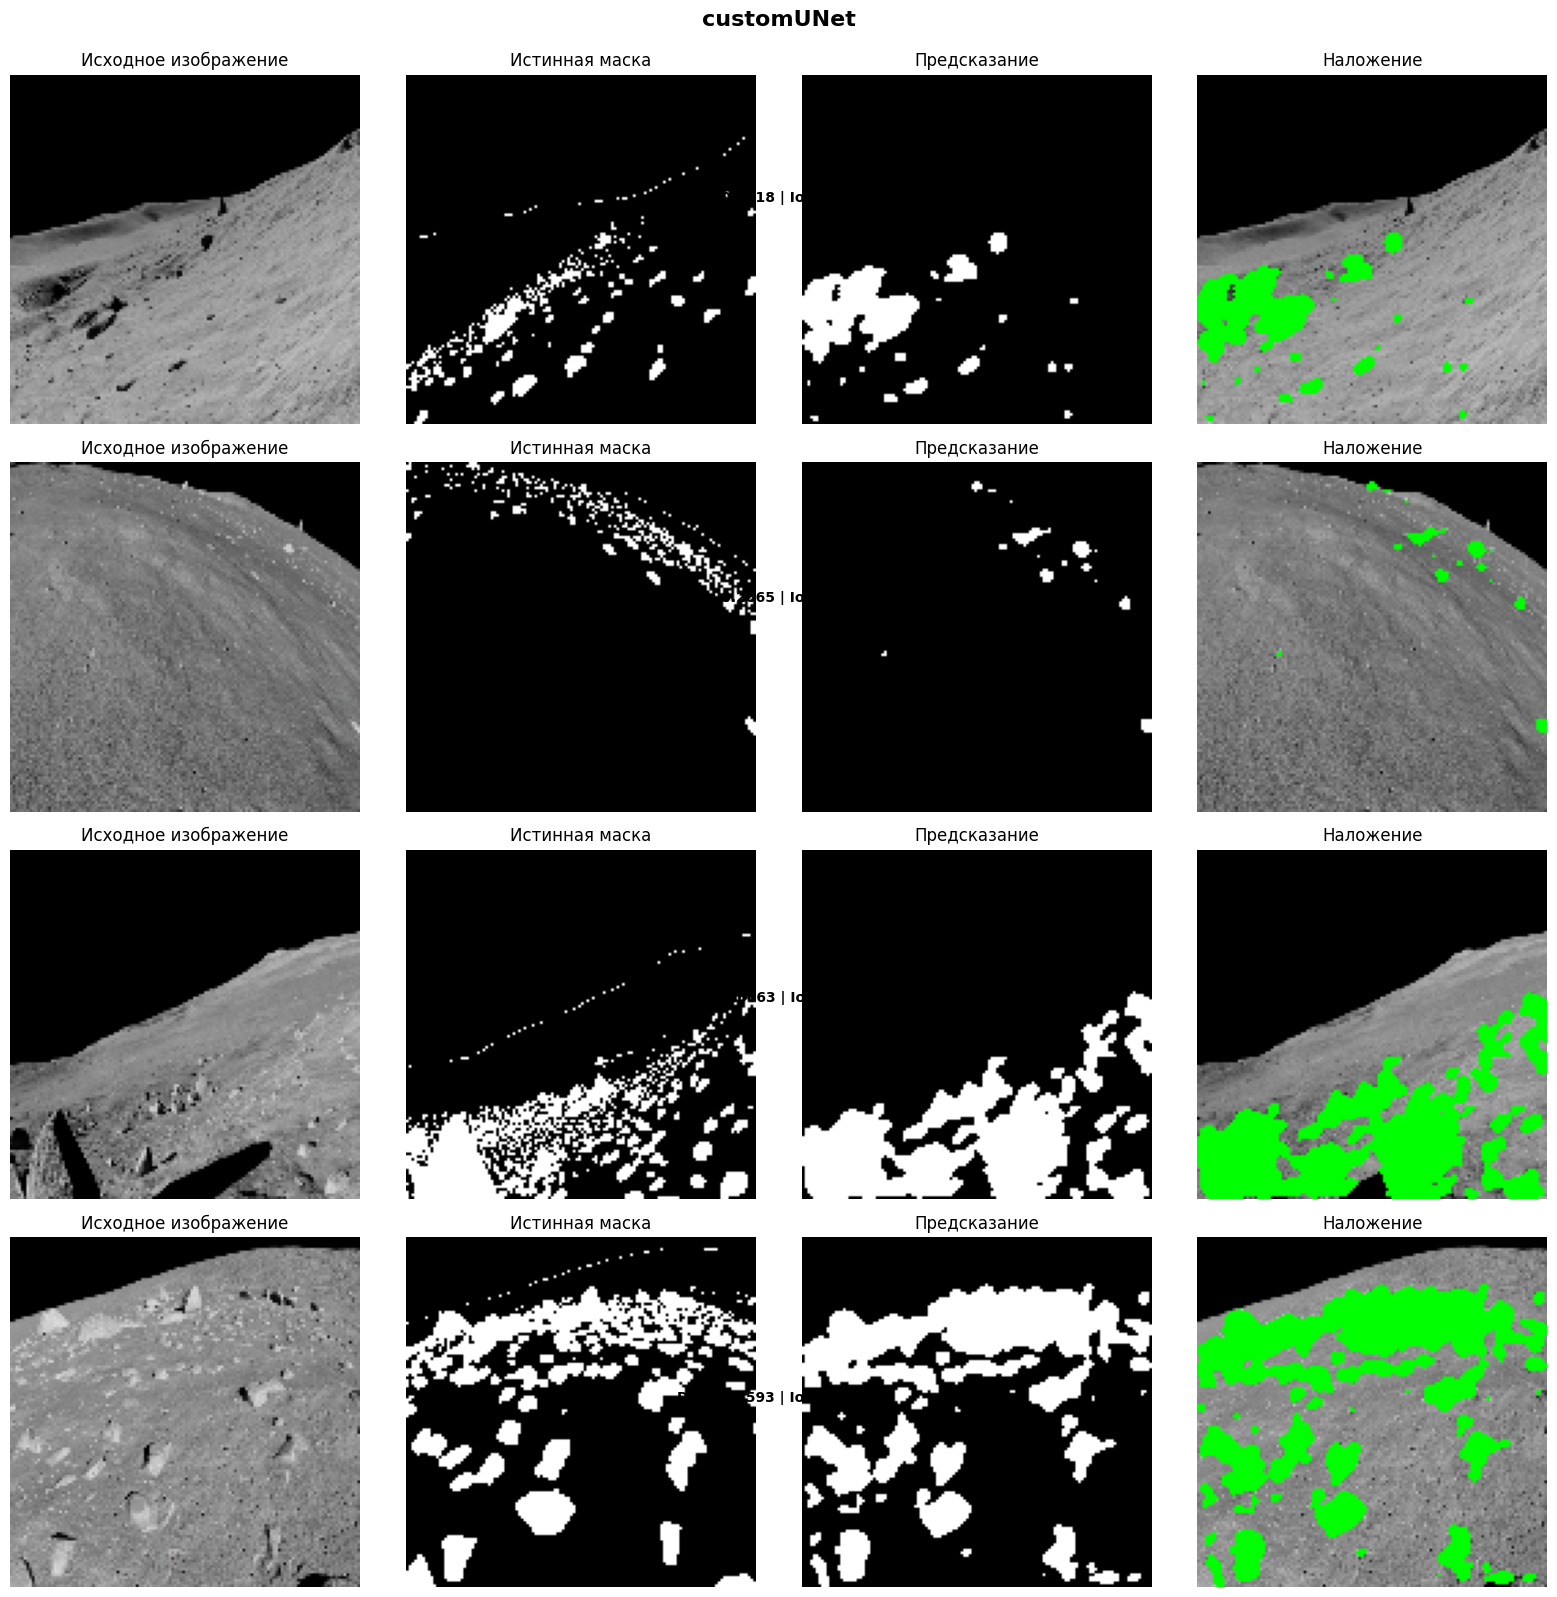

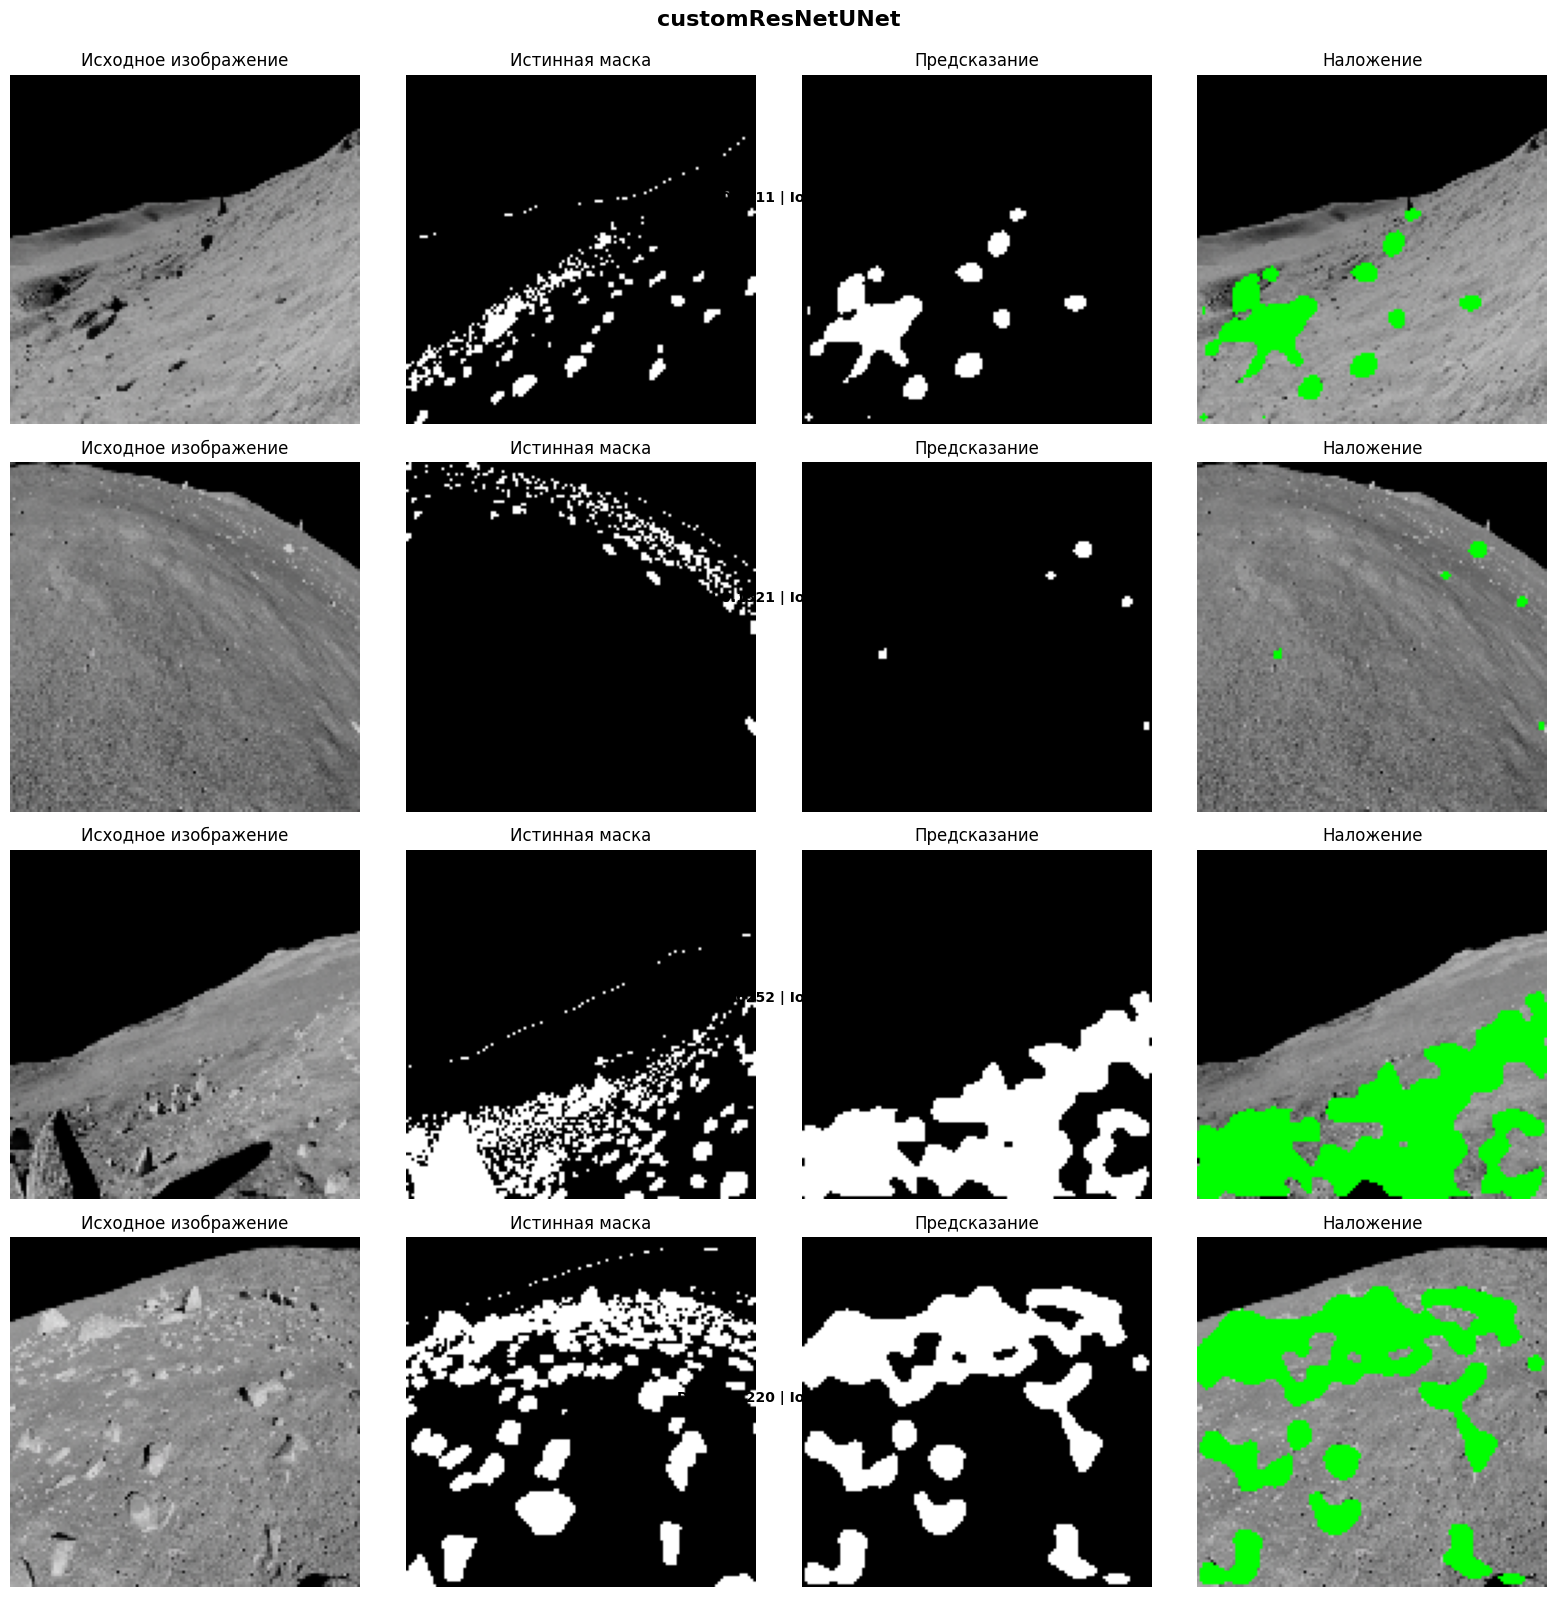

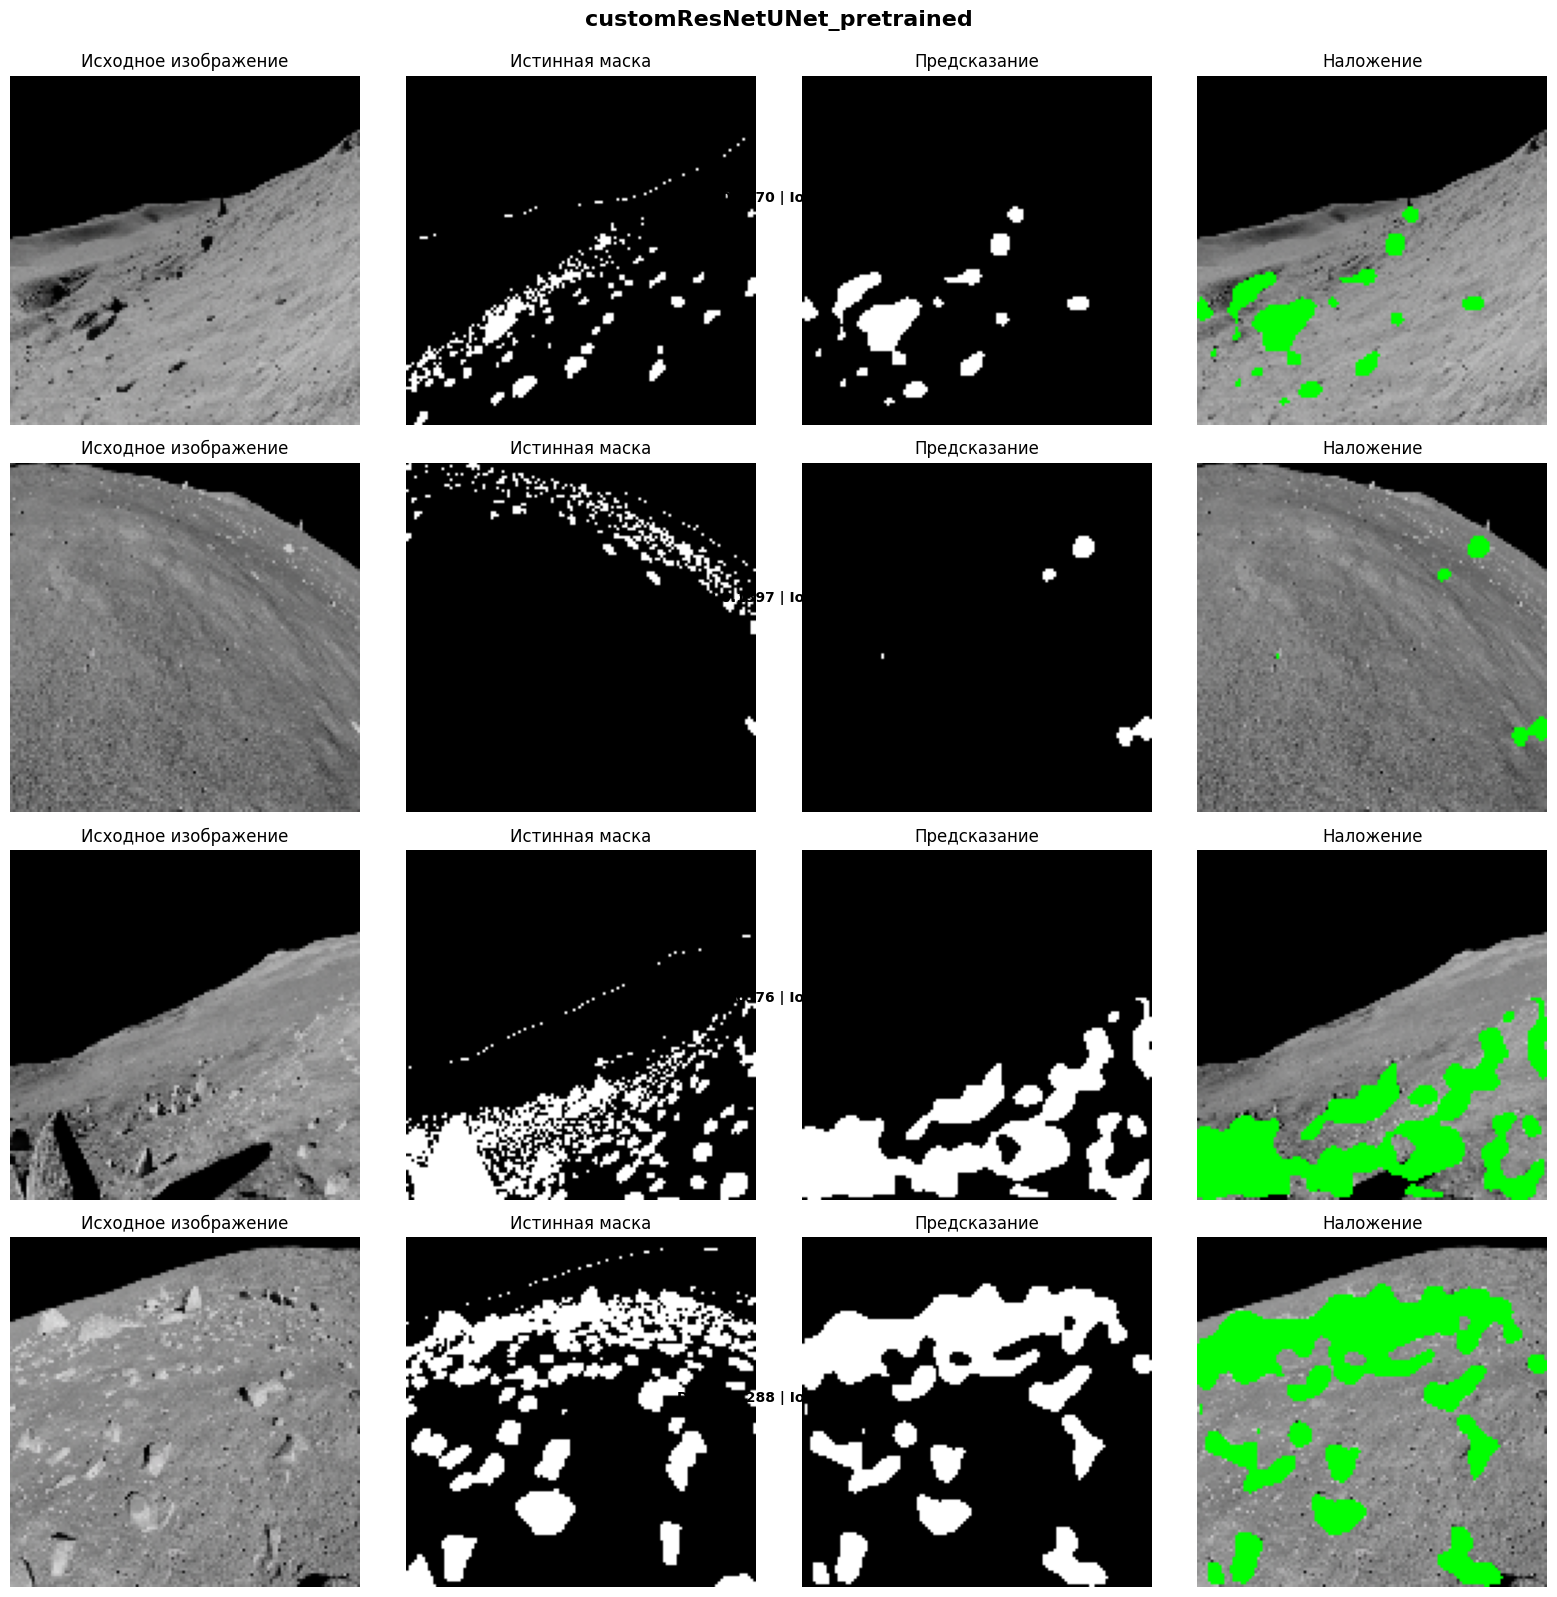

In [12]:
for name, model in zip(model_names, model_list):
    visualize_predictions(name, model, val_loader, device, num_samples=4)

Размер батча изображений: torch.Size([100, 3, 128, 128])
Размер батча масок: torch.Size([100, 1, 128, 128])


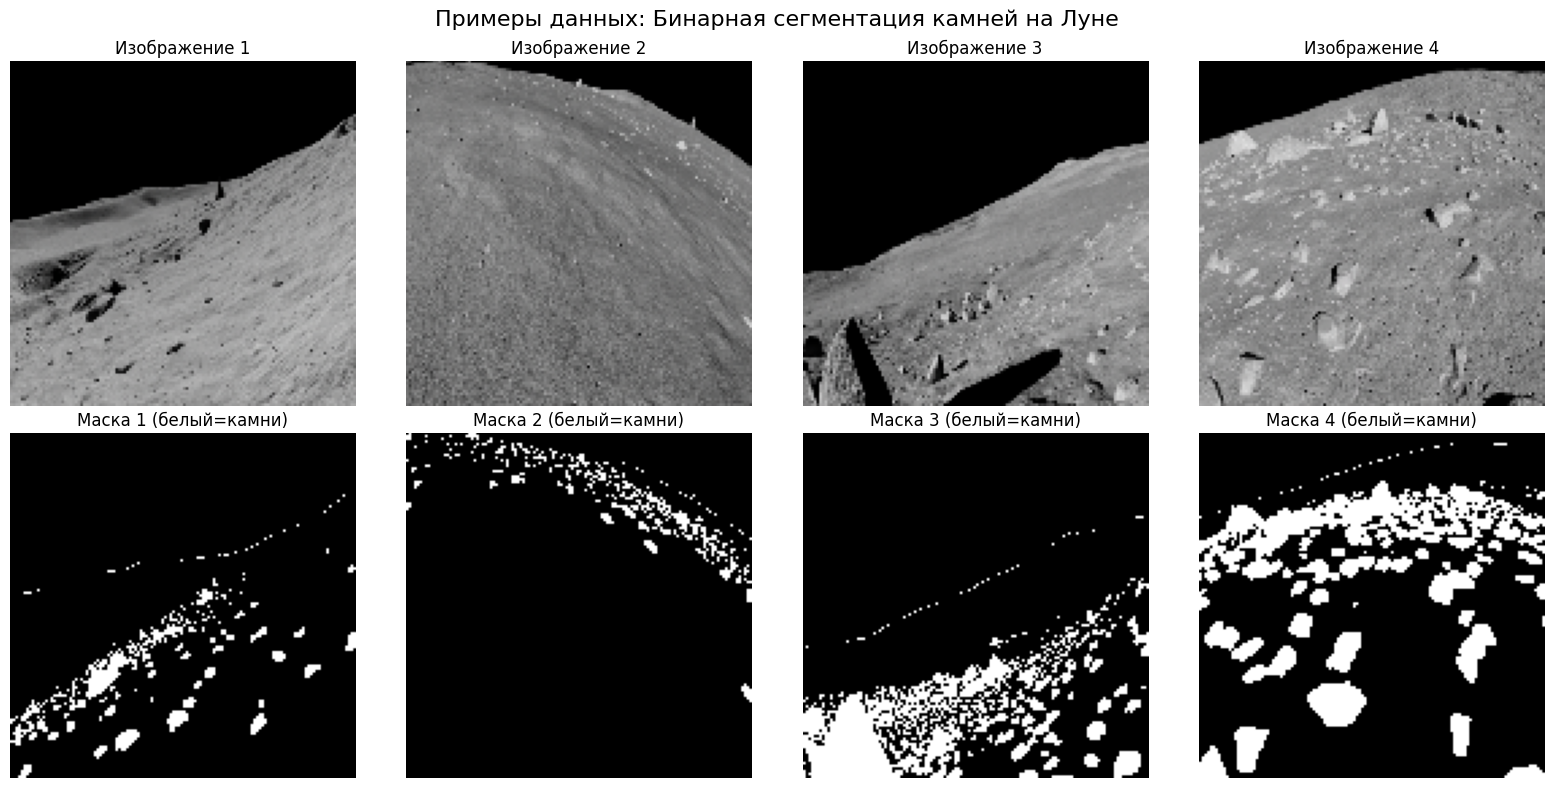

In [13]:
images, masks = next(iter(val_loader))

print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча масок: {masks.shape}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(images))):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    mask = masks[i].permute(1, 2, 0).numpy()
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
    axes[1, i].axis('off')

plt.suptitle("Примеры данных: Бинарная сегментация камней на Луне", fontsize=16)
plt.tight_layout()
plt.show()

Загрузка логов обучения.

In [18]:
user_figsize = (10, 24)

plot_titles = ["Losses", "dice", "IoU", "Accuracy"]
plot_ylabels = ["loss", "dice", "iou", "accuracy"]
METRIC_NUM = len(plot_titles)
line_type *= len(model_names)
plot_mark *= len(model_names)

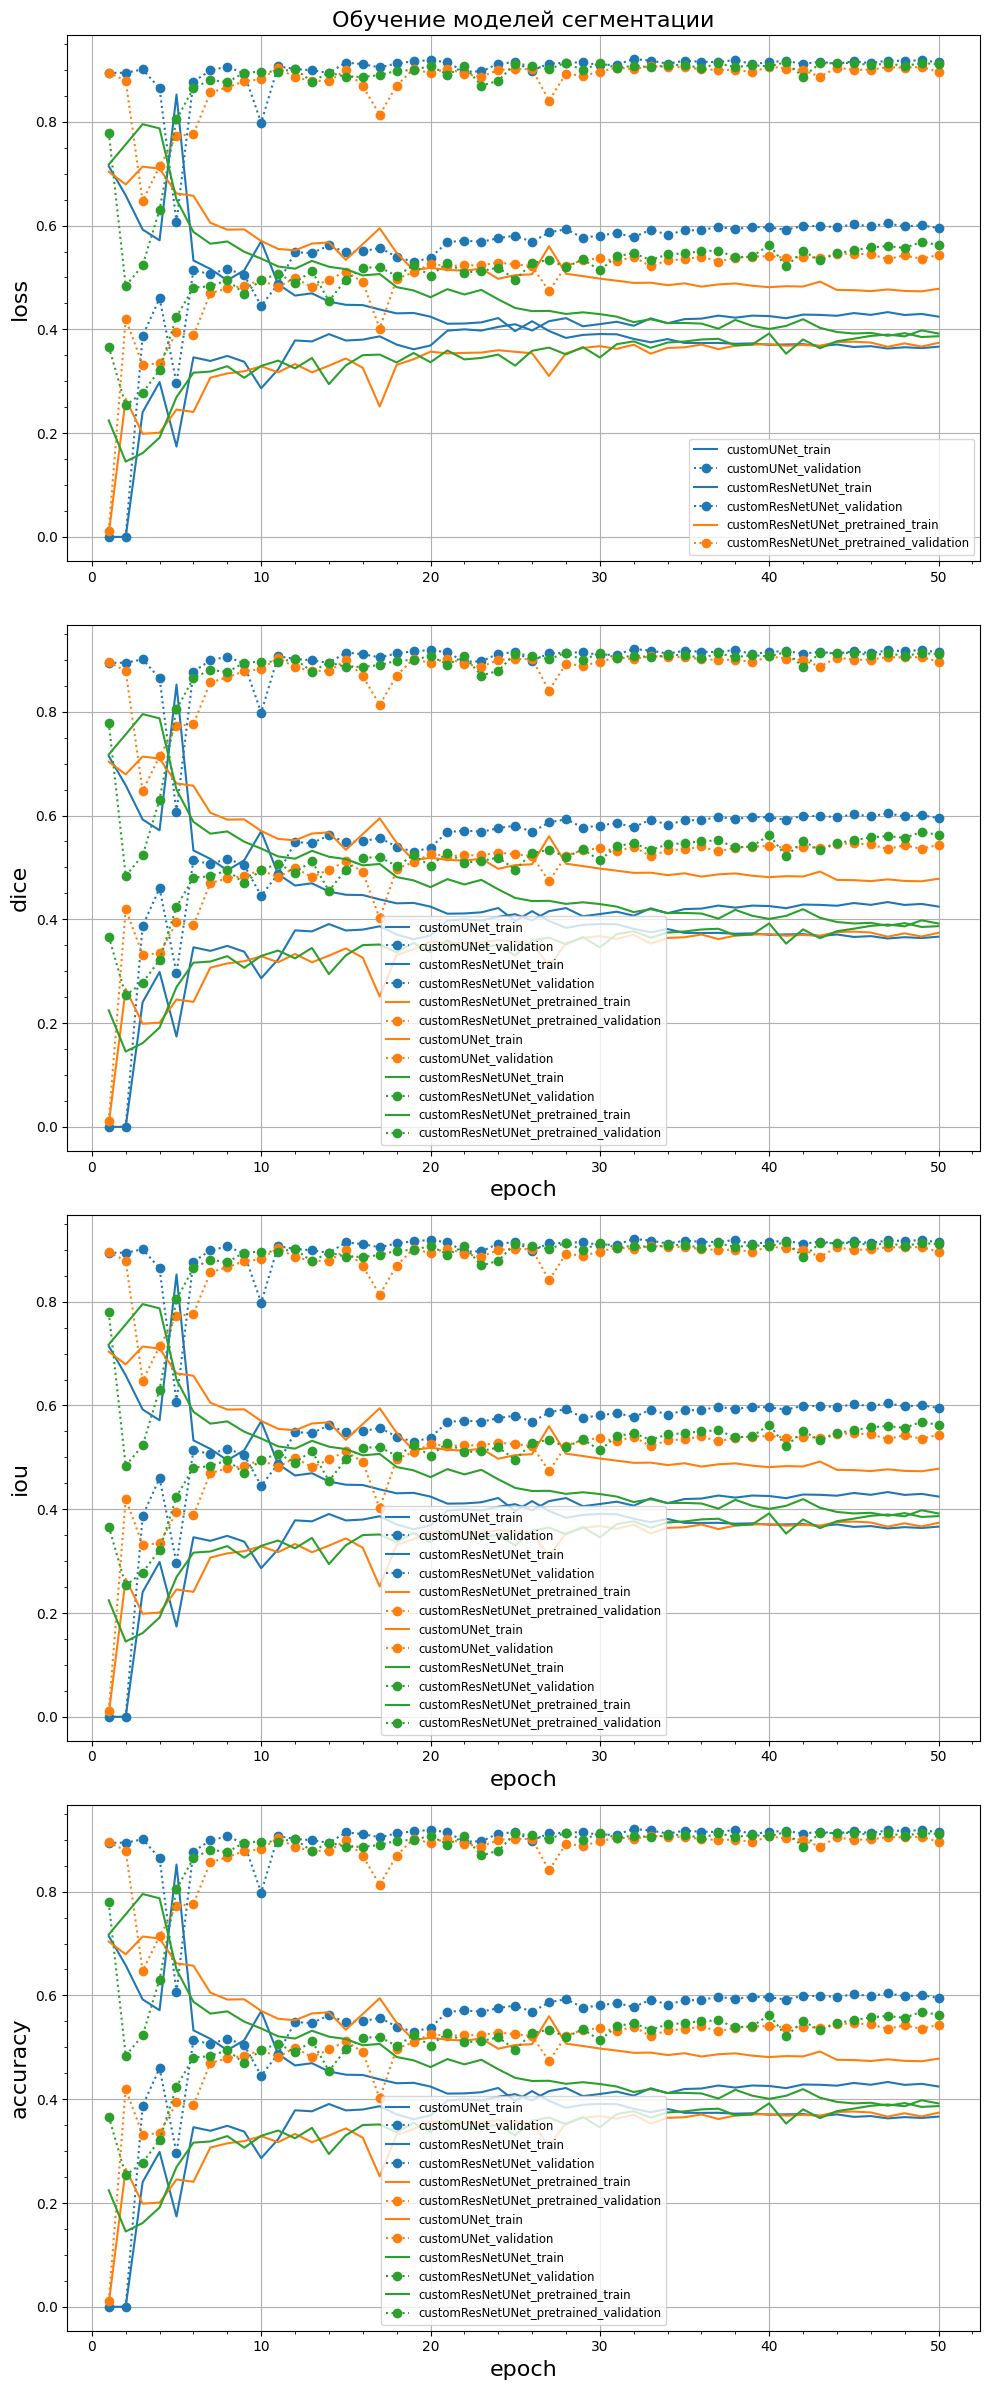

In [25]:
plot_idx = [
    usid.customUNet.value,
    usid.customResNetUNet.value,
    usid.customResNetUNet_pretrained.value
]

plot_legend_local = []
fig, axs = plt.subplots(ncols=1, nrows=METRIC_NUM, figsize=user_figsize)
for k, ax in enumerate(axs):
    if k == 0:
        ax.set_title("Обучение моделей сегментации", fontsize=user_fontsize)
    else:
        ax.set_xlabel(plot_xlabel, fontsize=user_fontsize)
    for idx in plot_idx:
        for m in range(METRIC_NUM):
            ax.plot(
                train_log_df_list[idx].iloc[:,0], 
                train_log_df_list[idx].iloc[:,2+m+METRIC_NUM],
                marker=plot_mark[m],
                linestyle=line_type[m],
                color=tab10_colors[idx]
                )
        plot_legend_local.extend([model_names[idx] + '_' + tp for tp in plot_legend])
    ax.set_ylabel(plot_ylabels[k], fontsize=user_fontsize)
    ax.legend(plot_legend_local, fontsize='small')
    ax.grid()
    ax.minorticks_on()
    
plt.tight_layout()
plt.savefig('readme_img/UNet.png', bbox_inches='tight')
plt.show()

In [24]:
train_log_df_list[idx]

epoch        lr  train_loss  train_dice  train_iou  train_accuracy  \
0       1  0.001000    0.681885    0.171040   0.094325        0.831970   
1       2  0.001000    0.641900    0.278316   0.162293        0.841135   
2       3  0.001000    0.607775    0.368621   0.226408        0.860487   
3       4  0.001000    0.582511    0.400580   0.250715        0.866810   
4       5  0.001000    0.565349    0.416879   0.263696        0.883115   
5       6  0.001000    0.546097    0.450382   0.290887        0.888339   
6       7  0.001000    0.534164    0.458679   0.297668        0.890244   
7       8  0.001000    0.526419    0.452517   0.292666        0.893743   
8       9  0.001000    0.520432    0.455358   0.295322        0.887873   
9      10  0.001000    0.508537    0.465518   0.303672        0.896201   
10     11  0.001000    0.502223    0.468058   0.305785        0.895587   
11     12  0.001000    0.498925    0.462970   0.301723        0.891821   
12     13  0.001000    0.488225    0.473850   0.311257        0.898642   
13     14  0.001000    0.481922    0.477949   0.314430        0.897822   
14     15  0.001000    0.471493    0.491863   0.326576        0.898214   
15     16  0.001000    0.463355    0.498551   0.332970        0.900978   
16     17  0.001000    0.460605    0.493973   0.328135        0.898820   
17     18  0.000500    0.455151    0.495878   0.330017        0.902058   
18     19  0.000500    0.448035    0.506371   0.339354        0.901782   
19     20  0.000500    0.442554    0.513412   0.345798        0.902672   
20     21  0.000500    0.444234    0.504703   0.337592        0.903231   
21     22  0.000500    0.434287    0.522983   0.354301        0.906487   
22     23  0.000500    0.432069    0.524053   0.355328        0.905439   
23     24  0.000500    0.427714    0.529846   0.360613        0.905867   
24     25  0.000500    0.429115    0.522721   0.354366        0.906074   
25     26  0.000500    0.425829    0.524554   0.355795        0.905526   
26     27  0.000500    0.424349    0.526237   0.357374        0.907166   
27     28  0.000500    0.422583    0.524907   0.356484        0.906332   
28     29  0.000500    0.423177    0.523327   0.354873        0.906243   
29     30  0.000500    0.419290    0.527068   0.358249        0.906250   
30     31  0.000500    0.414895    0.531919   0.362564        0.906823   
31     32  0.000250    0.410921    0.535768   0.366593        0.908102   
32     33  0.000250    0.407724    0.540790   0.370941        0.909436   
33     34  0.000250    0.407134    0.541356   0.371564        0.909459   
34     35  0.000250    0.407520    0.537908   0.368349        0.909405   
35     36  0.000125    0.406404    0.538587   0.369107        0.908547   
36     37  0.000125    0.403942    0.543801   0.373706        0.908248   
37     38  0.000125    0.397968    0.551513   0.380808        0.912179   
38     39  0.000125    0.397710    0.554409   0.383835        0.912401   
39     40  0.000125    0.401155    0.545966   0.375727        0.909921   
40     41  0.000125    0.400697    0.545469   0.375448        0.910889   
41     42  0.000125    0.395656    0.555144   0.384448        0.911712   
42     43  0.000125    0.393449    0.558714   0.387757        0.912616   
43     44  0.000125    0.392968    0.559652   0.388843        0.912150   
44     45  0.000125    0.392392    0.558053   0.387234        0.913105   
45     46  0.000125    0.393842    0.554427   0.384031        0.912612   
46     47  0.000125    0.389030    0.565001   0.394048        0.912896   
47     48  0.000125    0.391088    0.559678   0.388786        0.912705   
48     49  0.000125    0.393954    0.553226   0.382771        0.912116   
49     50  0.000125    0.393434    0.553090   0.382705        0.913560   

    val_loss      val_dice       val_iou  val_accuracy  
0   0.714327  5.807727e-12  5.807727e-12      0.894312  
1   0.658217  4.108881e-05  2.054485e-05      0.894315  
2   0.592325  3.874609e-01  2.403878e-01      0.900851  
3